In [1]:
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git

import sys
sys.path.insert(1, "../input/emojii")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 786.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3v9d7nh0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3v9d7nh0
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... - done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=17d581c31d5f23b3164ef0852cb1b3ebf54a71d12cafbe24a658b53a0e0a26ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-wpjr5f7q/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import clip
import torch
import re
from PIL import Image
import seaborn as sns
import string
import requests
from io import BytesIO
from emojii_and_emoticon_map import EMOTICONS_EMO, EMOJI_UNICODE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
device = "cuda" if torch.cuda.is_available() else "cpu"

/kaggle/input/emojii/emojii_and_emoticon_map.py
/kaggle/input/carousell-raw/carousell_raw.csv


In [3]:
df = pd.read_csv("/kaggle/input/carousell-raw/carousell_raw.csv")
df.head()

,Unnamed: 0,listing_link,product_name,img_url,listing_upload_date,condition,description
0,0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,54 minutes ago,Brand new,Description\nVISIT US AT OUR OFFICIAL WEBPAGE:...
1,1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,54 minutes ago,Brand new,Description\nVISIT US AT OUR OFFICIAL WEBPAGE:...
2,2,https://www.carousell.sg/p/decathlon-btwin-kid...,Decathlon Btwin Kids Bicycle 14 inch,https://media.karousell.com/media/photos/produ...,55 minutes ago,Well used,NaN
3,3,https://www.carousell.sg/p/kids-bicycle-decath...,Kids Bicycle - Decathlon,https://media.karousell.com/media/photos/produ...,2 hours ago,Lightly used,NaN
4,5,https://www.carousell.sg/p/bicycle-1259742120/...,Bicycle,https://media.karousell.com/media/photos/produ...,2 hours ago,Well used,NaN


In [4]:
meta_df = df.drop(columns=["Unnamed: 0", "product_name", "description", "condition"])

clean_df = df.drop(columns=["Unnamed: 0", "listing_link", "listing_upload_date"])
clean_df = clean_df.fillna(value={"description": ""})
clean_df.head(20)

,product_name,img_url,condition,description
0,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,Brand new,Description\nVISIT US AT OUR OFFICIAL WEBPAGE:...
1,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,Brand new,Description\nVISIT US AT OUR OFFICIAL WEBPAGE:...
2,Decathlon Btwin Kids Bicycle 14 inch,https://media.karousell.com/media/photos/produ...,Well used,
3,Kids Bicycle - Decathlon,https://media.karousell.com/media/photos/produ...,Lightly used,
4,Bicycle,https://media.karousell.com/media/photos/produ...,Well used,
5,Bicycle,https://media.karousell.com/media/photos/produ...,Like new,
6,360 Degree Rotation Silicone Bicycle Phone Hol...,https://media.karousell.com/media/photos/produ...,Brand new,
7,Fixie bicycle,https://media.karousell.com/media/photos/produ...,Like new,Description\nBought for my son but not to his ...
8,Foldable bike folding bicycle Dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,Brand new,Description\nReady stocks \n\nPrice starts fro...
9,Fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,Like new,Description\nSelling 2 Fnhon foldable bicycle ...


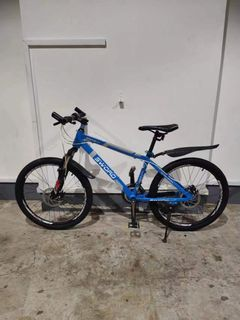

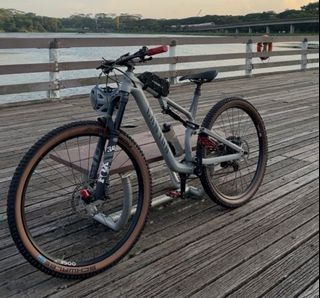

In [5]:
def url_to_img(url): 
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

url = clean_df["img_url"][200]
display(url_to_img(url))
url = clean_df["img_url"][10]
display(url_to_img(url)) # images are of different sizes, need to standardize

In [6]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 38.4MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [8]:
preprocess # image preprocessing

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7a751b603d90>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [9]:
# text preprocessing 

EMOTICONS_PATTERN = '|'.join(map(re.escape, EMOTICONS_EMO.keys()))
EMOJIS_PATTERN = '|'.join(map(re.escape, EMOJI_UNICODE.values()))
COMBINED_PATTERN = f"(?:{EMOTICONS_PATTERN})|(?:{EMOJIS_PATTERN})"
PATTERN = re.compile(COMBINED_PATTERN)

def remove_emojis_and_emoticons(text):
    return PATTERN.sub('', text)

def remove_punct(text):
    text = re.sub(r'\*\*|\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def mask_all(text):
    combined_pattern = r'(?:\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b)|' + \
                       r'(?:\+65\s?)?(?:\d{4}\s?\d{4})|' + \
                       r'(?:https?:\/\/www\.|https?:\/\/|www\.)[a-zA-Z0-9\.-]+\.[a-zA-Z]{2,}(\/\S*)?'
    
    masked_text = re.sub(combined_pattern, lambda x: '[email_masked]' if '@' in x.group(0) else 
                         ('[phone_masked]' if x.group(0).replace(' ', '').isdigit() or '+65' in x.group(0) else '[website_masked]'), text)
    
    return masked_text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

tqdm.pandas(desc="removing emojiis and emoticons from product name")
clean_df["product_name"] = clean_df["product_name"].progress_apply(remove_emojis_and_emoticons)

tqdm.pandas(desc="removing emojiis and emoticons from product description")
clean_df["description"] = clean_df["description"].progress_apply(remove_emojis_and_emoticons)

tqdm.pandas(desc="removing spaces and punctuation from product name")
clean_df["product_name"] = clean_df["product_name"].progress_apply(lambda x: remove_punct(x))

tqdm.pandas(desc="removing spaces and punctuation from product description")
clean_df["description"] = clean_df["description"].progress_apply(lambda x: remove_punct(x))

tqdm.pandas(desc="masking personal info from product name")
clean_df["product_name"] = clean_df["product_name"].progress_apply(mask_all)

tqdm.pandas(desc="masking personal info from product description")
clean_df["description"] = clean_df["description"].progress_apply(mask_all)

tqdm.pandas(desc="Removing punctuation from product name")
clean_df["product_name"] = clean_df["product_name"].progress_apply(remove_punctuation)

tqdm.pandas(desc="Removing punctuation from product description")
clean_df["description"] = clean_df["description"].progress_apply(remove_punctuation)

removing emojiis and emoticons from product name: 100%|██████████| 523/523 [00:00<00:00, 1244.50it/s]
removing emojiis and emoticons from product description: 100%|██████████| 523/523 [00:03<00:00, 161.47it/s]
removing spaces and punctuation from product name: 100%|██████████| 523/523 [00:00<00:00, 66964.44it/s]
removing spaces and punctuation from product description: 100%|██████████| 523/523 [00:00<00:00, 17667.41it/s]
Removing punctuation from product description: 100%|██████████| 523/523 [00:00<00:00, 27083.41it/s]


/tmp/ipykernel_26/3312329413.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df["condition"].fillna("unknown", inplace=True)


<Axes: xlabel='condition'>

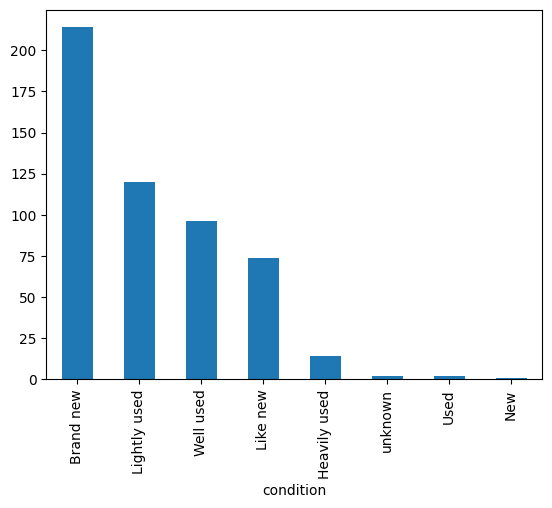

In [10]:
clean_df["condition"].fillna("unknown", inplace=True)
clean_df["condition"].value_counts().plot(kind='bar')

In [11]:
tqdm.pandas(desc="combined the text for CLIP tokenization")
clean_df['clean_text'] = clean_df.progress_apply(lambda x: f"The bicycle named '{x['product_name']}' is in {x['condition'].lower()} condition. {x['description']}", axis=1)

combined the text for CLIP tokenization: 100%|██████████| 523/523 [00:00<00:00, 41321.25it/s]


In [12]:
clean_df["clean_text"][0]

"The bicycle named 'INSTOCKS 26 inch single speed with Black Rim Wheel Bicycle Free Wheel with coaster brake  bike  Bicycle  Road Bicycle  Road Bike 13 Days Delivery ️WhatsApp phonemasked️ Goodmansg  Goodman  Good' is in brand new condition. Description VISIT US AT OUR OFFICIAL WEBPAGE httpswebsitemasked Brand New Instocks Now  Whole bicycle  Free assembly of bike  Comes with free maintenance tools Self collection or viewing at Yishun Interested please message  phonemasked You can pay when meetup For same day delivery to doorstep at 30 Specifications • Frame 18” High Carbon Steel Frame • Wheel 26 • Coaster Brake System  pedal backwards to brake • Weight approximately 125kg • Measurement 168 x 95cm Add on Bottle holder 6 Two led light 8 Bell at 3 Lock 10 Universal Bike Phone Holder 10 All above for 30 Add on Backrack 28 Add on Front and back handbrakes at 30 Add on Helmet 23"

In [13]:
def prepare_image(url):
    img = url_to_img(url)
    if img is not None:
        img_input = preprocess(img)
        return img_input
    else:
        return None

images = prepare_image(clean_df["img_url"][10]).cpu()

res = torch.tensor(np.stack(images)).cuda()
res

tensor([[[ 1.1128,  1.1128,  1.0982,  ...,  1.7406,  1.7552,  1.7844],
         [ 1.0836,  1.0836,  1.0836,  ...,  1.6676,  1.6530,  1.5946],
         [ 1.1128,  1.1128,  1.1274,  ...,  1.5070,  1.5946,  1.0544],
         ...,
         [-0.7120, -0.8434, -0.7704,  ...,  0.5727,  0.2953, -0.3616],
         [-0.8726, -0.6828, -0.4492,  ..., -0.0259, -0.4492, -0.0113],
         [-0.4638, -0.4346, -0.4930,  ..., -0.3324, -0.0259,  0.3391]],

        [[ 1.2495,  1.2495,  1.2344,  ...,  1.3695,  1.4145,  1.4746],
         [ 1.2194,  1.2194,  1.2194,  ...,  1.4145,  1.3995,  1.3845],
         [ 1.2495,  1.2495,  1.2645,  ...,  1.4145,  1.5046,  0.9643],
         ...,
         [-0.6265, -0.7616, -0.6865,  ...,  0.6642,  0.3790, -0.2963],
         [-0.7916, -0.5965, -0.3564,  ...,  0.0638, -0.3864,  0.0638],
         [-0.3714, -0.3414, -0.4014,  ..., -0.2663,  0.0488,  0.4240]],

        [[ 1.1647,  1.1647,  1.1505,  ...,  0.7381,  0.7950,  0.8945],
         [ 1.1363,  1.1363,  1.1363,  ...,  0

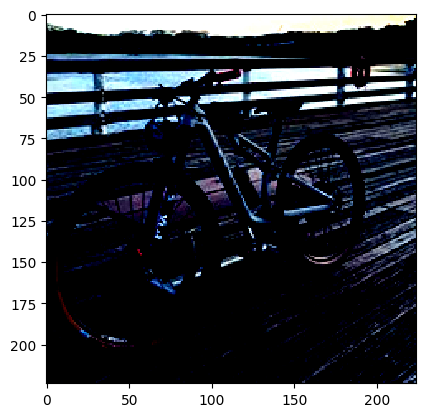

In [14]:
fig = plt.figure()
plt.imshow(res.cpu().permute(1, 2, 0), interpolation='nearest')

plt.show()

In [15]:
def prepare_image(url):
    img = url_to_img(url)
    if img is not None:
        img_input = preprocess(img)
        return img_input
    else:
        return None

image_tensors = [prepare_image(url) for url in tqdm(clean_df['img_url'].dropna(), desc='Processing images')]
image_tensors = [tensor for tensor in image_tensors if tensor is not None]
if image_tensors:
    image_input = torch.tensor(np.stack(image_tensors)).to(device)
else:
    image_input = torch.empty(0)
    
text_inputs = clip.tokenize([text for text in tqdm(clean_df['clean_text'], desc='Tokenizing text')], truncate=True).to(device)

Tokenizing text: 100%|██████████| 523/523 [00:00<00:00, 1013219.86it/s]


In [16]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_inputs).float()

In [17]:
print(image_features.shape)
print(text_features.shape)

torch.Size([523, 512])
torch.Size([523, 512])


## COSINE SIMILARITY

In [18]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

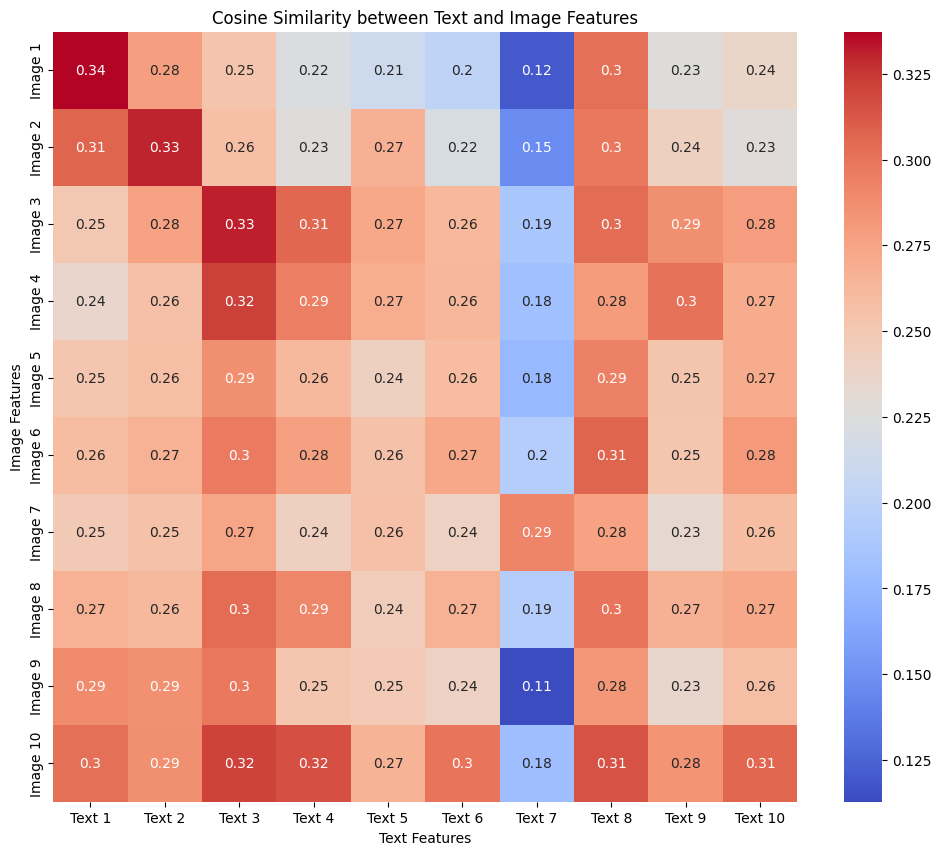

In [19]:
# Sample labels for demonstration purposes
image_labels = [f"Image {i+1}" for i in range(10)]
text_labels = [f"Text {i+1}" for i in range(10)]

# Assuming your similarity matrix is named `similarity`
# Select the first 10 rows and columns for visualization
similarity_subset = similarity[:10, :10]

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_subset, annot=True, cmap='coolwarm', xticklabels=text_labels, yticklabels=image_labels)
plt.title('Cosine Similarity between Text and Image Features')
plt.xlabel('Text Features')
plt.ylabel('Image Features')
plt.show()

## PUSHING INTO FAISS

In [20]:
# text_features = text_features.cpu().numpy()

In [21]:
# dim = text_features.shape[1]
# index = faiss.IndexFlatL2(dim)
# index.add(text_features)

In [22]:
# # Example query: Let's use the first item in text_features as a query
# query_vector = text_features[0:1]  # Reshape for a single query

# # Perform the search
# k = 5  # Number of nearest neighbors to find
# D, I = index.search(query_vector, k)  # D = distances, I = indices

# print("Indices of nearest neighbors:", I)
# print("Distances of nearest neighbors:", D)

In [23]:
# # %pip install faiss-gpu

# import faiss
# import numpy as np

# def create_faiss_index(text_embeddings):
#     dimension = text_embeddings[0].shape[0]  # Dimension of embeddings
#     index = faiss.IndexFlatL2(dimension)  # L2 distance for similarity
    
#     # If using GPU, uncomment the following line
#     faiss_res = faiss.StandardGpuResources()  # Use GPU resources
#     index = faiss.index_cpu_to_gpu(faiss_res, 0, index)
    
#     # Add embeddings to the index
#     index.add(np.array(text_embeddings).astype('float32'))  # Ensure embeddings are in float32 format for FAISS
    
#     return index

# # Example: Convert your text features DB to a list of embeddings and create the index
# text_embeddings = list(text_features)  # Assuming this is a list of np.array embeddings
# faiss_index = create_faiss_index(text_embeddings)

In [24]:
# def combined_similarity(query_text_feature, query_image_feature, text_features_db, image_features_db):
#     # Calculate text similarities
#     text_similarities = cosine_similarity(query_text_feature.reshape(1, -1), list(text_features_db.values()))
#     # Calculate image similarities
#     image_similarities = cosine_similarity(query_image_feature.reshape(1, -1), list(image_features_db.values()))
    
#     # Combine similarities (average for simplicity)
#     combined_similarities = (text_similarities + image_similarities) / 2.0
    
#     # Sort based on combined similarity
#     sorted_indices = np.argsort(combined_similarities[0])[::-1]
#     sorted_bikes = [list(text_features_db.keys())[i] for i in sorted_indices]
#     sorted_scores = combined_similarities[0][sorted_indices]
    
#     return sorted_bikes, sorted_scores

In [25]:
# sorted_bikes, scores = combined_similarity(query_text_feature, query_image_feature, text_features_db, image_features_db)
# print("Bikes sorted by combined similarity (most to least similar):", sorted_bikes)
# print("Combined similarity scores:", scores)